In [1]:
import numpy as np
import random
import powerlaw
import matplotlib.pyplot as plt 
import matplotlib.animation as animation
import warnings
warnings.filterwarnings("ignore")
import ipywidgets as widgets
from IPython.display import display, HTML
from IPython.display import clear_output
import matplotlib.pyplot as plt
import ipywidgets as widgets
from PIL import Image, ImageDraw
import pandas as pd
import scipy.special as sp
import scipy.linalg as sl
import matplotlib.pyplot as plt
from scipy.stats import skewnorm
from itertools import islice
import time
import copy
%pip install -upgrade ipywidgets
clear_output()
#update

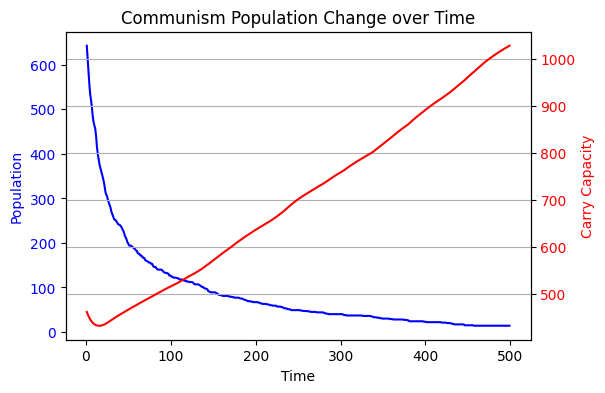

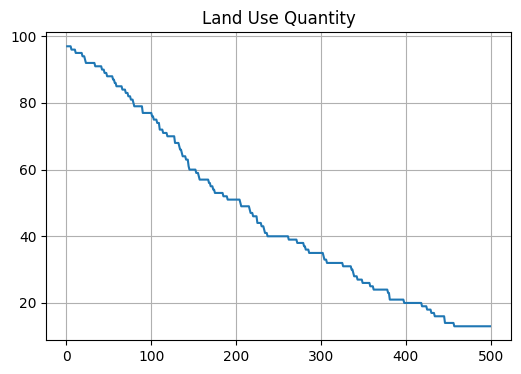

In [100]:
import copy
vec1 = pd.read_csv('demog_vectors.csv')
# everyone has the same farming capacity. It doesn't matter who farms.
def communism_simulation_population_original(vec1, k, a, initial_lands, simulation_time, K_star_t, num_household):
    def family_num(max_size_family, num_household):
        num_lst = np.arange(1, max_size_family + 1)
        mean = (max_size_family + 1) / 2
        std_dev = (max_size_family + 1) / 4
        # calculate the PDF of the normal distribution for the num_lst
        weights = (1 / (std_dev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((num_lst - mean) / std_dev) ** 2)
        nums = random.choices(num_lst, weights=weights, k=num_household)
        return nums
    
    def carry_capacity(max_size_family):  
        num_lst = np.arange(1, max_size_family + 1)
        weights = (1.0 / num_lst) ** 1.5  # Calculate power-law weights
        weights /= np.sum(weights)  # Normalize the weights to sum up to 1
        num = random.choices(num_lst, weights=weights, k=10000)  # Increase the number of samples for a better plot
        return num
    
    def calculate_effectiveness_and_consumption(population_matrix, vec1):
        phi = vec1.phi  # Worker effectiveness parameter
        rho = vec1.rho  # Consumption parameter    
        max_lands = np.sum(population_matrix * phi) # change it to support
        consumption = np.sum(population_matrix * rho)
        return round(max_lands), consumption

    np.random.seed(42)
    def generate_left_skewed_proportions(num_elements):
        data = skewnorm.rvs(a=-2, loc=0.4, scale=0.2, size=num_elements)
        data = data[data >= 0]
        proportions = data / np.sum(data)
        # ensure that there are exactly num_elements proportions (padding with zeros if necessary)
        if len(proportions) < num_elements:
            proportions = np.append(proportions, [0] * (num_elements - len(proportions)))
        return proportions
    initial_fam_sizes = family_num(max_size_family, num_household) 

    num_p0_rows = vec1.shape[0]
    family_demands = {} 
    age_proportions = generate_left_skewed_proportions(num_p0_rows)
    age_proportions = np.array(age_proportions) / np.sum(age_proportions)
    if len(age_proportions) < num_p0_rows: # make sure age_proportions matches the number of rows in vec1
        age_proportions = np.append(age_proportions, 0)  # add a zero proportion for the extra age group
    family_demands = {}
    family_demands[0] = {}
    for i in range(len(initial_fam_sizes)):
        population_matrix = np.random.multinomial(i, age_proportions)       
        max_lands, consumption = calculate_effectiveness_and_consumption(population_matrix, vec1)
        family_demands[0][i] = {'family_number': i, 'family_matrix': population_matrix, 'demands': consumption, 'land_number': None} 

    def update_population_matrix(population_matrix, vec1, z):
        p0 = vec1.pstar * sp.gdtr(1.0 / vec1.mortscale[0], vec1.mortparms, z)
        m0 = vec1.mstar * sp.gdtr(1.0 / vec1.fertscale[0], vec1.fertparm[0], z)
        if z > 1.5: m0 *= z
        if z < 1.2: m0 *= z
        N = len(p0)
        m1 = np.zeros([N, N])
        for i in range(N - 1):
            m1[i + 1, i] = p0[i]
        for i in range(N):     # simulate survival for each individual in each age group using the Bernoulli distribution.
            num_survived = np.random.binomial(population_matrix[i], p0[i])
            population_matrix[i] = num_survived
        return population_matrix

    t = 0
    #updating storage    
    populations = [sum(initial_fam_sizes)]  # store population values over time
    u_values = [[0] for _ in range(simulation_time)] # using land or not decision
    L_values = carry_capacity(max_size_family)
    K_values = [] # land carry capacity  
    
    land_assignments = {} 
    land_assignments[0] = {} # setting ownership: assigning land capacity to each farmer in the zero year
    for i in range(initial_lands): 
                land_assignments[0][i] = { 
                    'land_number': i, #land numbering
                    'carry_capacity': L_values[i],
                    'usage': None
                }

    def land_assign(land_assignments, t, max_lands, family_demands):
        sorted_land_assignments = sorted(land_assignments[t].items(), key=lambda item: item[1]['carry_capacity'], reverse=True)
        sorted_family_demands = sorted(family_demands[t].items(), key=lambda item: item[1]['demands'], reverse=True)  
        for idx, (family_number, demands_dict) in enumerate(sorted_family_demands):
            if idx < len(sorted_land_assignments):
                land_number = sorted_land_assignments[idx][0]
                land_capacity = sorted_land_assignments[idx][1]['carry_capacity']
                demands_dict['land_number'] = land_number
                demands_dict['land_capacity'] = land_capacity
            else:
                demands_dict['land_number'] = None
                demands_dict['land_capacity'] = 0
        return sorted_land_assignments, sorted_family_demands
    land_assign(land_assignments, t, max_lands, family_demands)

    ### Updating process for each year
    for t in range(1, simulation_time): # time 0 is already updated
        family_demands[t] = copy.deepcopy(family_demands[t-1])
        families_to_delete = set()
        for family_info in family_demands[t].values():
        ########################## old year ##########################
            land_number = family_info['land_number']
            demands = family_info['demands']
            P = land_assignments[t-1][land_number]['carry_capacity']
            
            z = P / demands # food availability parameter == carry capacity in my case
            population_matrix_old = family_info['family_matrix']
            ########################## new year ##########################
            population_matrix = update_population_matrix(population_matrix_old, vec1, z)
            population_matrix[np.isnan(population_matrix)] = 0
            family_info['family_matrix'] = population_matrix
            max_lands, consumption = calculate_effectiveness_and_consumption(family_info['family_matrix'], vec1)
            family_info['demands'] = consumption
            if consumption == 0: 
                families_to_delete.add(family_info['family_number'])
                # print(family_info['family_number'])
        for i in families_to_delete: del family_demands[t][i]
        ########################## after updating the family info ##########################
        selected_lands = []
        for family_info in family_demands[t].values():
            land_number_value = family_info['land_number']
            selected_lands.append(land_number_value)

        land_assignments[t] = {} # adding a sub-dict in each year, an old one.
        for i in range(initial_lands): #should I give everyone an agent identity?
                land_assignments[t][i] = {
                    'land_number': i, #land numbering
                    'carry_capacity': None,
                    'usage': 0
                }

        for i in selected_lands: land_assignments[t][i]['usage'] = 1 
        u_t = [land_assignments[t][i]['usage'] for i in range (initial_lands)] # get to use the land or not binary value u
        K_t_natural = [land_assignments[t-1][i]['carry_capacity'] for i in range(initial_lands)] #from the land_assignment dict, get all the land capacities in the looping year.

    #   updating land capacity
        for i in range(initial_lands):
            land_assignments[t][i]['carry_capacity'] = max(0, min(K_star_t, land_assignments[t-1][i]['carry_capacity'] + k * (K_star_t - land_assignments[t-1][i]['carry_capacity'])  - a * K_t_natural[i] * u_t[i])) ############
        
        ########################## migration ##########################
        land_assign(land_assignments, t, max_lands, family_demands)
        ################################################################
        sum_of_populations = []
        for family_info in family_demands[t].values():
            pop = np.sum(family_info['family_matrix'])
            sum_of_populations.append(pop)
        K_t_plus_1 = [land_assignments[t][i]['carry_capacity'] for i in range(initial_lands)] ## list of each land cell capacity (new year, this year)
        populations.append(sum(sum_of_populations))
        K_values.append(sum(K_t_plus_1)) # total land capacity
        u_values[t-1] = u_t # update the land usage (Y/N)
    populations = populations[1:] # exclude the zero year population 
    return populations, K_values, u_values, land_assignments, family_demands
    
def plot_commuism_simulation_population2(vec1, k, a, initial_lands, simulation_time, K_star_t, num_household):
    
    populations, K, U, _, family = communism_simulation_population_original(vec1, k, a, initial_lands, simulation_time, K_star_t, num_household)
    
    time_steps = range(1, simulation_time)

    fig, ax1 = plt.subplots(figsize=(6, 4))

    # Plot population on the first y-axis
    ax1.plot(time_steps, populations, color='blue', label='Population')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Population', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Create a secondary y-axis and plot carry capacity on it
    ax2 = ax1.twinx()
    ax2.plot(time_steps, K, color='red', label='Carry Capacity')
    ax2.set_ylabel('Carry Capacity', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    plt.grid(True)
    plt.title('Communism Population Change over Time')
    plt.show()
    
    fig = plt.figure(figsize=(6, 4))
    plt.plot(time_steps, [sum(i) for i in U][:-1])
    plt.grid(True)
    plt.title('Land Use Quantity')
    plt.show()

k = 0.01 # land recovery rate
a = 0.04 # soil loss rate
simulation_time = 500 #simulation year
num_household = 100
initial_lands = 200
K_star_t = 7
max_size_family = 10
plot_commuism_simulation_population2(vec1, k, a, initial_lands, simulation_time, K_star_t, num_household)

### Parameter Experiments

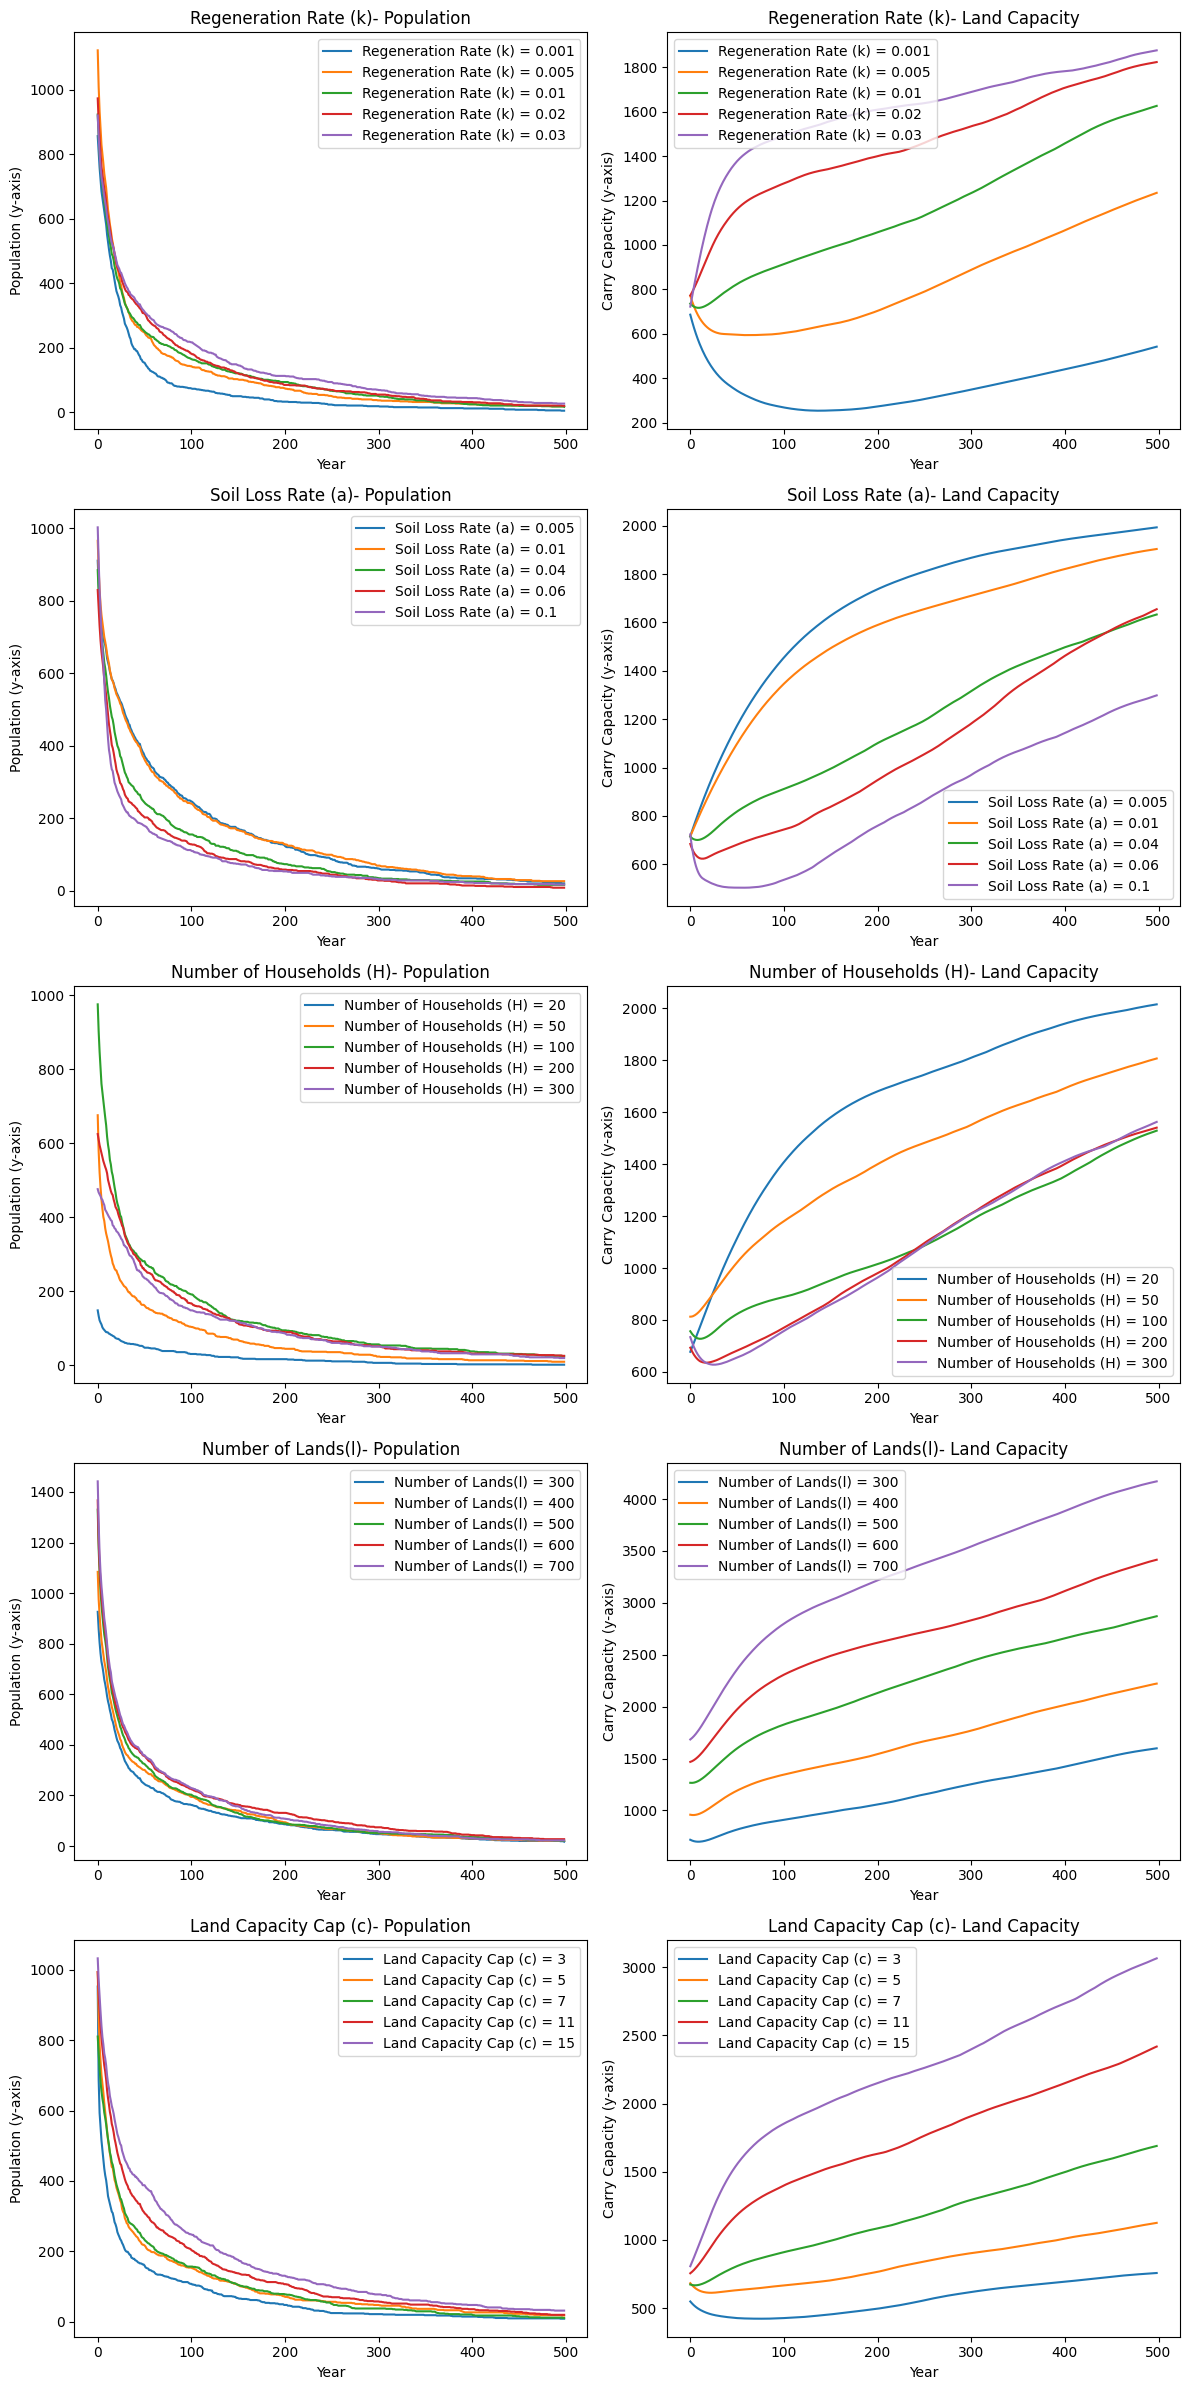

In [102]:
## number of lands > number of household
k_range = [0.001, 0.005, 0.01, 0.02, 0.03] #recovering
a_range = [0.005, 0.01, 0.04, 0.06, 0.1] #depletion rate
h_range = [20, 50, 100, 200, 300] #initial household
l_range = [300, 400, 500, 600, 700] #initial lands
c_range = [3, 5, 7, 11, 15] #land capacity cap

baseline_k = 0.01  # Select a baseline value for k
baseline_a = 0.04  # Select a baseline value for a
baseline_h = 100  # Select a baseline value for i
baseline_l = 300  # Select a baseline value for d
baseline_c = 7  # Select a baseline value for c

# Vary k while keeping other parameters constant
k_result_pop = []
k_result_food = []
for k in k_range:
    result, cap, _, _, _ = communism_simulation_population_original(vec1, k, baseline_a, baseline_l, simulation_time, baseline_c, baseline_h)
    k_result_pop.append(result)
    k_result_food.append(cap)

# Vary a while keeping other parameters constant
a_result_pop = []
a_result_food = []
for a in a_range:
    result, cap, _, _, _ = communism_simulation_population_original(vec1, baseline_k, a, baseline_l, simulation_time, baseline_c, baseline_h)
    a_result_pop.append(result)
    a_result_food.append(cap)

# Vary d while keeping other parameters constant
h_result_pop = []
h_result_food = []
for h in h_range:
    result, cap, _, _, _ = communism_simulation_population_original(vec1, baseline_k, baseline_a, baseline_l, simulation_time, baseline_c, h)
    h_result_pop.append(result)
    h_result_food.append(cap)

# Vary d while keeping other parameters constant
l_result_pop = []
l_result_food = []
for l in l_range:
    result, cap, _, _, _ = communism_simulation_population_original(vec1, baseline_k, baseline_a, l, simulation_time, baseline_c, baseline_h)
    l_result_pop.append(result)
    l_result_food.append(cap)

# Vary c while keeping other parameters constant
c_result_pop = []
c_result_food = []
for c in c_range:
    result, cap, _, _, _ = communism_simulation_population_original(vec1, baseline_k, baseline_a, baseline_l, simulation_time, c, baseline_h)
    c_result_pop.append(result)
    c_result_food.append(cap)

parameters = [('Regeneration Rate (k)', k_range, k_result_pop, k_result_food),
              ('Soil Loss Rate (a)', a_range, a_result_pop, a_result_food),
              ('Number of Households (H)', h_range, h_result_pop, h_result_food),
              ('Number of Lands(l)', l_range, l_result_pop, l_result_food),
              ('Land Capacity Cap (c)', c_range, c_result_pop, c_result_food)]

fig, axs = plt.subplots(len(parameters), 2, figsize=(12, 24))

for i, (param_name, param_range, result_pop, result_food) in enumerate(parameters):
    for j in range(len(param_range)):
        axs[i, 0].plot(result_pop[j], label=f'{param_name} = {param_range[j]}')
    
    axs[i, 0].set_xlabel('Year')
    axs[i, 0].set_ylabel('Population (y-axis)')
    axs[i, 0].set_title(param_name + "- Population")
    axs[i, 0].legend()

    for j in range(len(param_range)):
        axs[i, 1].plot(result_food[j], label=f'{param_name} = {param_range[j]}')
    
    axs[i, 1].set_xlabel('Year')
    axs[i, 1].set_ylabel('Carry Capacity (y-axis)')
    axs[i, 1].set_title(param_name + "- Land Capacity")
    axs[i, 1].legend()

plt.tight_layout()
plt.show()

### Experimenting

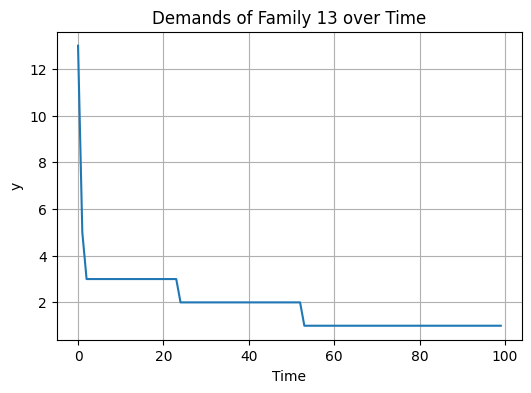

In [86]:
family_number_to_plot = 13
demands_of_family_1 = [np.sum(family_info['family_matrix']) for t in range(simulation_time) for family_info in family[t].values() if family_info['family_number'] == family_number_to_plot]

fig = plt.figure(figsize=(6, 4))
plt.plot(range(simulation_time), demands_of_family_1)
plt.xlabel('Time')
plt.ylabel('y')
plt.grid(True)
plt.title(f'Demands of Family {family_number_to_plot} over Time')
plt.show()


### Animation

In [104]:
populations, K, U, data, _ = communism_simulation_population_original(vec1, k, a, initial_lands, simulation_time, K_star_t, num_household)

# Define the dimension of the grid
grid_dim = int(np.sqrt(max(data[0].keys())))

# Create a colormap
cmap = plt.get_cmap('RdYlBu')


# Function to render the animation for a given year
def render_animation(year):
    # Get the data for the current year
    year_data = data.get(year, {})

    # Create an image with a white background
    image = Image.new('RGBA', (grid_dim * 100, grid_dim * 100), color=(255, 255, 255, 0))
    draw = ImageDraw.Draw(image)

    if year_data:
        # Iterate over each land cell for the current year
        for land_number, land_data in sorted(year_data.items()):
            usage = land_data.get('usage', 0)
            # Map the usage to a color
            color = (51, 102, 0) if usage == 1 else (255, 255, 255)

            # Calculate the position of the land cell
            x = (land_number % grid_dim) * 100
            y = (land_number // grid_dim) * 100

            # Draw a rectangle representing the land cell
            draw.rectangle([(x, y), (x + 100, y + 100)], fill=color)

    return image
# Create a list to store the animation frames
animation_frames = []

# Iterate over each year and generate frames
for year in range(max(data.keys()) + 1):
    image = render_animation(year)
    animation_frames.append(image)
    
animation_frames[0].save('usage_self_village.gif', format='GIF', append_images=animation_frames[1:], save_all=True, duration=200, loop=0, optimize=True)
display(widgets.Image(value=open('usage_self_village.gif', 'rb').read()))


Image(value=b'GIF89ax\x05x\x05\x87\x00\x00\xff\xff\xff\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00…